In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, StepLR
from torchvision import models, transforms
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score

import time
import copy
from tqdm import tqdm

In [3]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# getting base_path and folder names
base_path = "data/IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)

In [5]:
# # getting total number of images
# total_images = 0
# for n in range(len(folder)):
#     patient_id = folder[n]
#     for c in [0, 1]:
#         patient_path = base_path + patient_id 
#         class_path = patient_path + "/" + str(c) + "/"
#         subfiles = os.listdir(class_path)
#         total_images += len(subfiles)
# total_images

In [6]:
# # storing image_path, patient_id and the target
# data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

# k = 0
# for n in range(len(folder)):
#     patient_id = folder[n]
#     patient_path = base_path + patient_id 
#     for c in [0,1]:
#         class_path = patient_path + "/" + str(c) + "/"
#         subfiles = os.listdir(class_path)
#         for m in range(len(subfiles)):
#             image_path = subfiles[m]
#             data.iloc[k]["path"] = class_path + image_path
#             data.iloc[k]["target"] = c
#             data.iloc[k]["patient_id"] = patient_id
#             k += 1  

# data.loc[:, "target"] = data.target.astype(np.str_)
# data.info()
# data.head()

# # save data
# data.to_csv(base_path + "data", index=False)

In [6]:
data = pd.read_csv(base_path + "data")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277270 entries, 0 to 277269
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277270 non-null  int64 
 1   path        277270 non-null  object
 2   target      277270 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.3+ MB


,patient_id,path,target
0,13402,data/IDC_regular_ps50_idx5/13402/0/13402_idx5_...,0
1,13402,data/IDC_regular_ps50_idx5/13402/0/13402_idx5_...,0
2,13402,data/IDC_regular_ps50_idx5/13402/0/13402_idx5_...,0
3,13402,data/IDC_regular_ps50_idx5/13402/0/13402_idx5_...,0
4,13402,data/IDC_regular_ps50_idx5/13402/0/13402_idx5_...,0


In [7]:
# splitting the data into train, test and val
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                            test_size=0.3,
                                            random_state=0)
test_ids, val_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [8]:
print(len(train_ids)/patients.shape[0]*100, len(val_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


In [9]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int64)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int64)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

In [10]:
# Set paths and parameters
data_dir = "data"

BATCH_SIZE = 32
NUM_CLASSES = 2
NUM_EPOCHS = 20

OUTPUT_PATH = ""
MODEL_PATH = "breast_cancer_model/"
LOSSES_PATH = "breast_cancer_model/"

In [11]:
# creating a dataframe containing the paths for the different datasets
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
val_df = data.loc[data.patient_id.isin(val_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
val_df = extract_coords(val_df)

In [12]:
# Data preprocessing and augmentation
def my_transform(key="train"):
    train_sequence = [
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), # type: ignore
        transforms.Resize((50, 50)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
    ]
    val_sequence = [
        transforms.Resize((50, 50))
    ]
    
    if key == "train":
        transform = transforms.Compose(train_sequence + [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose(val_sequence + [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    return transform

In [14]:
# Custom Dataset class
class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.states = df
        self.transform = transform
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        target = np.int64(self.states.target.values[idx]) if "target" in self.states.columns.values else None
        
        try:
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except (OSError, IOError) as e:
            # print(f"Error opening image file: {image_path}. Skipping image.")
            return self.__getitem__((idx + 1) % len(self))
        
        return {
            "image": image,
            "label": target,
            "patient_id": patient_id,
            "x": x_coord,
            "y": y_coord
        }

In [13]:
# Custom Dataclass for SiameseDataset
class BreastCancerSiameseDataset(Dataset):
    def __init__(self, df, transform=None):
        self.states = df
        self.transform = transform
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        target = np.int64(self.states.target.values[idx]) if "target" in self.states.columns.values else None
        
        try:
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except (OSError, IOError) as e:
            # print(f"Error opening image file: {image_path}. Skipping image.")
            return self.__getitem__((idx + 1) % len(self))
        
        # Select a random sample from the same class
        random_idx = np.random.choice(np.where(self.states.target.values == target)[0])
        random_image_path = self.states.path.values[random_idx]
        try:
            random_image = Image.open(random_image_path).convert("RGB")
            if self.transform:
                random_image = self.transform(random_image)
        except (OSError, IOError) as e:
            # print(f"Error opening image file: {random_image_path}. Skipping image.")
            return self.__getitem__((idx + 1) % len(self))
        
        return {
            "image1": image,
            "image2": random_image,
            "label": target,
            "patient_id": patient_id,
            "x": x_coord,
            "y": y_coord
        }

In [14]:
# # Load and split the dataset
# train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
# val_dataset = BreastCancerDataset(val_df, transform=my_transform(key="val"))
# test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

# Load and split the dataset siamese set
train_dataset = BreastCancerSiameseDataset(train_df, transform=my_transform(key="train"))
val_dataset = BreastCancerSiameseDataset(val_df, transform=my_transform(key="val"))
test_dataset = BreastCancerSiameseDataset(test_df, transform=my_transform(key="val"))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [17]:
# Define the model
def get_model(pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    return model

In [18]:
def get_resnet18(pretrained=False):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, NUM_CLASSES)
    )
    return model

In [19]:
def get_resnet50(pretrained=False):
    model = models.resnet50(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, NUM_CLASSES)
    )
    return model

In [15]:
# Define the Siamese CNN architecture
class SiameseCNN(nn.Module):
    def __init__(self):
        super(SiameseCNN, self).__init__()
        self.feature_extractor = models.resnet50(pretrained=True)
        num_ftrs = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(num_ftrs, 1024)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x1, x2):
        feat1 = self.feature_extractor(x1)
        feat2 = self.feature_extractor(x2)
        out1 = self.classifier(feat1)
        out2 = self.classifier(feat2)
        return out1, out2

In [21]:
def get_inceptionv3(pretrained=False):
    model = models.inception_v3(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    aux_in_features = model.AuxLogits.fc.in_features

    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, NUM_CLASSES)
    )
    model.AuxLogits.fc = nn.Sequential(
        nn.Linear(aux_in_features, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, NUM_CLASSES)
    )
    return model

In [22]:
def get_densenet(pretrained=False):
    model = models.densenet121(pretrained=pretrained)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, NUM_CLASSES)
    )
    return model

In [23]:
def get_efficientnet(pretrained=False):
    model = EfficientNet.from_pretrained("efficientnet-b0") if pretrained else EfficientNet.from_name("efficientnet-b0")
    num_ftrs = model._fc.in_features
    model._fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, NUM_CLASSES)
    )
    return model

In [24]:
def get_squeezenet(pretrained=False):
    model = models.squeezenet1_1(pretrained=pretrained)
    model.num_classes = NUM_CLASSES
    model.classifier[1] = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=1),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
    )
    model.classifier[3] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
    model.num_classes = NUM_CLASSES
    return model

In [16]:
# Model initialization

# model = get_resnet18(pretrained=False)
# model = get_resnet50(pretrained=False)
# model = get_inceptionv3(pretrained=False)
# model = get_densenet(pretrained=False)
# model = get_efficientnet(pretrained=False)
# model = get_squeezenet(pretrained=False)
# Create an instance of the Siamese CNN model
model = SiameseCNN()
model.to(device)


# model_type = "resnet18"
# model_type = "resnet50"
# model_type = "inceptionv3"
# model_type = "densenet"
# model_type = "efficientnet"
# model_type = "squeezenet"
model_type = "siamese-cnn"

version = "v1"

# Comment when doing Siamese model
# model = model.to(device)

In [26]:
# weights = compute_class_weight(y=train_df["target"].values, class_weight="balanced", classes=train_df["target"].unique())    
# class_weights = torch.FloatTensor(weights)
# if device.type=="cuda":
#     class_weights = class_weights.cuda()
# print(class_weights)

In [17]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# parameters = list(model.parameters())  # Get the model's parameters as a list
# optimizer = optim.Adam(parameters, lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [18]:
# Define the learning rate range for cyclic LR
base_lr = 1e-6
max_lr = 0.006

# Set up the cyclic learning rate scheduler
# step_size = len(train_loader) * 2  # Number of iterations per half cycle
# step_size = NUM_EPOCHS * 2  # Number of iterations per half cycle
# scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size)  # Learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Define the learning rate range for stepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

In [29]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, device, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = {"train": [], "val": [], "test": []}
    accuracies = {"train": [], "val": [], "test": []}
    precisions = []
    f1_scores = []
    recalls = []
    
    for epoch in range(num_epochs):
        print("=" * 80)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("=" * 80)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            progress_bar = tqdm(dataloader, desc=f"{phase} Batch", leave=False)
            for data in progress_bar:
                inputs = data["image"].to(device)
                labels = data["label"].to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update the progress bar description
                progress_bar.set_postfix(loss=loss.item())
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset) # type: ignore
            
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            
            print(f"{phase} Loss: {epoch_loss*100:.2f} Acc: {epoch_acc*100:.2f}")
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Evaluate on the test set
        model.eval()
        running_test_loss = 0.0
        running_test_corrects = 0
        test_preds = []
        test_labels = []
        
        progress_bar = tqdm(test_loader, desc="Test Batch", leave=False)
        for data in progress_bar:
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            running_test_loss += loss.item() * inputs.size(0)
            running_test_corrects += torch.sum(preds == labels.data)
            
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            
            # Update the progress bar description
            progress_bar.set_postfix(loss=loss.item())
        
        test_loss = running_test_loss / len(test_loader.dataset)
        test_acc = running_test_corrects.double() / len(test_loader.dataset) # type: ignore
        test_precision = precision_score(test_labels, test_preds, average="macro")
        test_recall = recall_score(test_labels, test_preds, average="macro")
        test_f1 = f1_score(test_labels, test_preds, average="macro")
        
        losses["test"].append(test_loss)
        accuracies["test"].append(test_acc)
        precisions.append(test_precision)
        recalls.append(test_recall)
        f1_scores.append(test_f1)
        
        print(f"Test Loss: {test_loss*100:.2f} Acc: {test_acc*100:.2f}")
        print(f"Test Precision: {test_precision*100:.2f}")
        print(f"Test Recall: {test_recall*100:.2f}")
        print(f"Test F1 Score: {test_f1*100:.2f}")
        
        scheduler.step(test_acc)
    
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies, precisions, recalls, f1_scores

In [19]:
def train_model_siamese(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, device, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = {"train": [], "val": [], "test": []}
    accuracies = {"train": [], "val": [], "test": []}
    precisions = []
    recalls = []
    f1_scores = []
    
    for epoch in range(num_epochs):
        print("=" * 80)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("=" * 80)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            progress_bar = tqdm(dataloader, desc=f"{phase} Batch", leave=False)
            for data in progress_bar:
                inputs1 = data["image1"].to(device)
                inputs2 = data["image2"].to(device)
                labels = data["label"].to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs1, outputs2 = model(inputs1, inputs2)
                    _, preds1 = torch.max(outputs1, 1)
                    _, preds2 = torch.max(outputs2, 1)
                    loss = criterion(outputs1, labels) + criterion(outputs2, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs1.size(0)
                running_corrects += torch.sum(preds1 == labels.data) + torch.sum(preds2 == labels.data)
                
                # Update the progress bar description
                progress_bar.set_postfix(loss=loss.item())
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / (2 * len(dataloader.dataset))  # Since we have two predictions per pair
            
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            
            print(f"{phase} Loss: {epoch_loss*100:.2f} Acc: {epoch_acc*100:.2f}")
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Evaluate on the test set
        model.eval()
        running_test_loss = 0.0
        running_test_corrects = 0
        test_preds = []
        test_labels = []
        
        progress_bar = tqdm(test_loader, desc="Test Batch", leave=False)
        for data in progress_bar:
            inputs1 = data["image1"].to(device)
            inputs2 = data["image2"].to(device)
            labels = data["label"].to(device)
            
            with torch.no_grad():
                outputs1, outputs2 = model(inputs1, inputs2)
                _, preds1 = torch.max(outputs1, 1)
                _, preds2 = torch.max(outputs2, 1)
                loss = criterion(outputs1, labels) + criterion(outputs2, labels)
            
            running_test_loss += loss.item() * inputs1.size(0)
            running_test_corrects += torch.sum(preds1 == labels.data) + torch.sum(preds2 == labels.data)
            
            test_preds.extend(preds1.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            
            # Update the progress bar description
            progress_bar.set_postfix(loss=loss.item())
        
        test_loss = running_test_loss / len(test_loader.dataset)
        test_acc = running_test_corrects.double() / (2 * len(test_loader.dataset))  # Since we have two predictions per pair
        test_precision = precision_score(test_labels, test_preds, average="macro")
        test_recall = recall_score(test_labels, test_preds, average="macro")
        test_f1 = f1_score(test_labels, test_preds, average="macro")
        
        losses["test"].append(test_loss)
        accuracies["test"].append(test_acc)
        precisions.append(test_precision)
        recalls.append(test_recall)
        f1_scores.append(test_f1)
        
        print(f"Test Loss: {test_loss*100:.2f} Acc: {test_acc*100:.2f}")
        print(f"Test Precision: {test_precision*100:.2f}")
        print(f"Test Recall: {test_recall*100:.2f}")
        print(f"Test F1 Score: {test_f1*100:.2f}")
        
        scheduler.step(test_acc)
    
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies, precisions, recalls, f1_scores

In [31]:
# # Train the model
# best_model, losses, accuracies, precisions, recalls, f1_scores = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, device, num_epochs=NUM_EPOCHS)

# Train the model
best_model, losses, accuracies, precisions, recalls, f1_scores = train_model_siamese(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, device, num_epochs=NUM_EPOCHS)

Epoch 1/20


train Loss: 66.59 Acc: 85.81


val Loss: 61.67 Acc: 86.76


Test Loss: 59.54 Acc: 87.27
Test Precision: 85.26
Test Recall: 84.67
Test F1 Score: 84.95
Epoch 2/20


train Loss: 59.46 Acc: 87.47


val Loss: 58.70 Acc: 87.38


Test Loss: 59.20 Acc: 87.24
Test Precision: 86.38
Test Recall: 83.04
Test F1 Score: 84.42
Epoch 3/20


train Loss: 56.65 Acc: 88.15


val Loss: 56.91 Acc: 87.97


Test Loss: 55.69 Acc: 88.19
Test Precision: 86.46
Test Recall: 85.25
Test F1 Score: 85.81
Epoch 4/20


train Loss: 55.22 Acc: 88.37


val Loss: 58.32 Acc: 87.57


Test Loss: 56.82 Acc: 88.09
Test Precision: 86.64
Test Recall: 84.87
Test F1 Score: 85.67
Epoch 5/20


train Loss: 53.65 Acc: 88.75


val Loss: 55.85 Acc: 88.30


Test Loss: 57.96 Acc: 87.73
Test Precision: 86.36
Test Recall: 84.23
Test F1 Score: 85.17
Epoch 6/20


train Loss: 52.63 Acc: 89.02


val Loss: 61.83 Acc: 86.74


Test Loss: 60.48 Acc: 86.97
Test Precision: 84.26
Test Recall: 86.60
Test F1 Score: 85.22
Epoch 7/20


train Loss: 51.43 Acc: 89.26


val Loss: 59.09 Acc: 87.59


Test Loss: 57.48 Acc: 87.88
Test Precision: 85.60
Test Recall: 85.94
Test F1 Score: 85.77
Epoch 8/20


train Loss: 50.47 Acc: 89.45


val Loss: 58.19 Acc: 87.97


Test Loss: 57.42 Acc: 87.99
Test Precision: 86.36
Test Recall: 85.02
Test F1 Score: 85.64
Epoch 9/20


train Loss: 49.78 Acc: 89.65


val Loss: 61.29 Acc: 87.56


Test Loss: 58.24 Acc: 87.93
Test Precision: 85.94
Test Recall: 85.69
Test F1 Score: 85.81
Epoch 10/20


train Loss: 48.64 Acc: 89.90


val Loss: 63.37 Acc: 87.37


Test Loss: 59.49 Acc: 87.83
Test Precision: 85.76
Test Recall: 85.62
Test F1 Score: 85.69
Epoch 11/20


train Loss: 47.82 Acc: 90.06


val Loss: 60.69 Acc: 87.70


Test Loss: 62.16 Acc: 87.60
Test Precision: 85.50
Test Recall: 84.82
Test F1 Score: 85.14
Epoch 12/20


train Loss: 47.29 Acc: 90.19


val Loss: 65.57 Acc: 87.07


Test Loss: 61.87 Acc: 87.05
Test Precision: 84.71
Test Recall: 85.60
Test F1 Score: 85.13
Epoch 13/20


train Loss: 46.32 Acc: 90.48


val Loss: 60.28 Acc: 87.62


Test Loss: 60.11 Acc: 87.71
Test Precision: 85.92
Test Recall: 84.73
Test F1 Score: 85.29
Epoch 14/20


train Loss: 45.86 Acc: 90.54


val Loss: 62.40 Acc: 87.37


Test Loss: 60.34 Acc: 87.31
Test Precision: 85.73
Test Recall: 84.14
Test F1 Score: 84.86
Epoch 15/20


train Loss: 44.74 Acc: 90.80


val Loss: 63.63 Acc: 87.16


Test Loss: 63.86 Acc: 87.31
Test Precision: 85.09
Test Recall: 85.20
Test F1 Score: 85.14
Epoch 16/20


train Loss: 44.18 Acc: 90.94


val Loss: 68.65 Acc: 86.80


Test Loss: 64.60 Acc: 86.99
Test Precision: 84.59
Test Recall: 85.97
Test F1 Score: 85.22
Epoch 17/20


train Loss: 43.47 Acc: 91.09


val Loss: 64.62 Acc: 87.62


Test Loss: 65.97 Acc: 87.21
Test Precision: 85.34
Test Recall: 84.41
Test F1 Score: 84.85
Epoch 18/20


train Loss: 42.67 Acc: 91.26


val Loss: 62.41 Acc: 87.68


Test Loss: 61.99 Acc: 87.60
Test Precision: 85.31
Test Recall: 85.71
Test F1 Score: 85.51
Epoch 19/20


train Loss: 42.19 Acc: 91.37


val Loss: 66.19 Acc: 86.25


Test Loss: 66.84 Acc: 86.40
Test Precision: 83.79
Test Recall: 84.56
Test F1 Score: 84.15
Epoch 20/20


train Loss: 41.28 Acc: 91.60


val Loss: 67.91 Acc: 86.99


Test Loss: 66.09 Acc: 87.25
Test Precision: 86.09
Test Recall: 83.21
Test F1 Score: 84.43


In [20]:
# Train the model
best_model, losses, accuracies, precisions, recalls, f1_scores = train_model_siamese(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, device, num_epochs=1)

Epoch 1/1


train Loss: 66.52 Acc: 85.81


val Loss: 61.39 Acc: 87.03


Test Loss: 58.28 Acc: 87.70
Test Precision: 85.92
Test Recall: 84.98
Test F1 Score: 85.43


In [32]:
# Save the best model
# torch.save(best_model.state_dict(), MODEL_PATH + "best_model.pth")

torch.save(best_model.state_dict(), f"{MODEL_PATH}{model_type}/best_model{version}({model_type}).pth")
# torch.save(best_model, f"{MODEL_PATH}{model_type}/best_model{version}({model_type}).pth")

In [33]:
def convert_accuracies_to_numpy_arrays(accuracies):
    train_accuracies = np.array([tensor.cpu() for tensor in accuracies["train"]])
    val_accuracies = np.array([tensor.cpu() for tensor in accuracies["val"]])
    test_accuracies = np.array([tensor.cpu() for tensor in accuracies["test"]])
    return train_accuracies, val_accuracies, test_accuracies

In [34]:
# Convert the losses to NumPy arrays
train_losses = np.array(losses["train"])
val_losses = np.array(losses["val"])
test_losses = np.array(losses["test"])

# Convert te accuracies to NumPy arrays
train_accuracies, val_accuracies, test_accuracies = convert_accuracies_to_numpy_arrays(accuracies)

# Save the training and validation losses
losses_df = pd.DataFrame({"train_loss": train_losses, "val_loss": val_losses, "test_loss": test_losses})
losses_df.to_csv(f"{LOSSES_PATH}{model_type}/losses{version}({model_type}).csv", index=False)

# Save the training and validation accuracies
accuracies_df = pd.DataFrame({"train_acc": train_accuracies, "val_acc": val_accuracies, "test_acc": test_accuracies})
accuracies_df.to_csv(f"{LOSSES_PATH}{model_type}/accuracies{version}({model_type}).csv", index=False)

In [35]:
# Metrics from the test
metrics_dict = {
    "accuracy" : [round(accuracy * 100, 2) for accuracy in test_accuracies],
    "loss" : [round(loss * 100, 2) for loss in test_losses],
    "precison" : [round(precise * 100, 2) for precise in precisions],
    "recall" : [round(recall * 100, 2) for recall in recalls],
    "f1_scores" : [round(f1 * 100, 2) for f1 in f1_scores],
}

metrics = pd.DataFrame(metrics_dict)
metrics.to_csv(f"{MODEL_PATH}{model_type}/metrics{version}({model_type}).csv", index=False)
metrics

,accuracy,loss,precison,recall,f1_scores
0,87.27,59.54,85.26,84.67,84.95
1,87.24,59.20,86.38,83.04,84.42
2,88.19,55.69,86.46,85.25,85.81
3,88.09,56.82,86.64,84.87,85.67
4,87.73,57.96,86.36,84.23,85.17
5,86.97,60.48,84.26,86.60,85.22
6,87.88,57.48,85.60,85.94,85.77
7,87.99,57.42,86.36,85.02,85.64
8,87.93,58.24,85.94,85.69,85.81
9,87.83,59.49,85.76,85.62,85.69


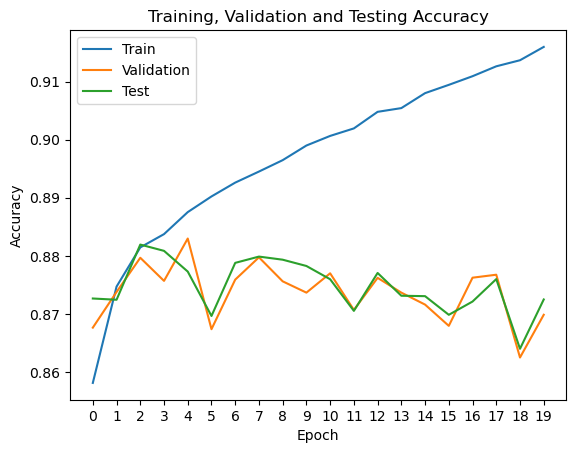

In [36]:
# Plot the accuracy
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.plot(test_accuracies, label="Test")
plt.xticks(np.arange(len(test_accuracies)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training, Validation and Testing Accuracy")
plt.legend();

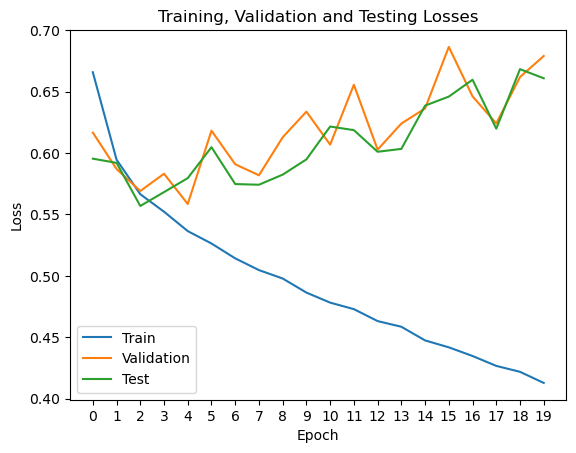

In [37]:
# Plot the losses
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.plot(test_losses, label="Test")
plt.xticks(np.arange(len(test_losses)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation and Testing Losses")
plt.legend();